In [1]:
%matplotlib inline
# generic
import os, sys, time, datetime, collections, re, random, asyncio
from IPython.display import display
from timeit import default_timer as timer
from tqdm import tqdm, trange
import numpy as np
import pandas as pd

import ag.bittensor.utils.options as options
import ag.bittensor.ai.make_data as make_data
import ag.bittensor.utils.talib as talib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ohlc
from matplotlib.finance import volume_overlay3
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator,
                              WeekdayLocator, date2num)

from sklearn import datasets

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

c:\users\kinet\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [6]:
# Funcs
def get_all_data():
    all_data = {}
    while True:
        filename = datasmith.next_filename
        if filename is None: break
        datasmith.dataframe = filename
        all_data[filename[:-4]] = datasmith.dataframe
    return all_data

def get_one_data():
    filename = datasmith.random_filename
    datasmith.dataframe = filename
    return datasmith.dataframe

def unzero(df):
    df = df.replace(0,'NaN')
    df = df.dropna(how='all',axis=0)
    df = df.replace('NaN', 0)
    df.len = len(df)
    return df

In [7]:
# Globals
datasmith = make_data.MakeData()
get_all = False  # This is the flag for big data or single data
EVALUATION_COIN = 'ZCL_BTC'

In [8]:
start = timer()
if get_all:
    dataset = get_all_data()
    btc_pairs = [x for x in mega_set if 'BTC' in x]
    btc_set = {}
    for i in dataset:
        if i in btc_pairs:
            btc_set[i] = dataset[i]
    highvol_set = {}
    volumes = []
    pairs = []
    for i in btc_set:
        btc_vol = btc_set[i]['baseVolume'][0] * btc_set[i]['last'][0]
        if btc_vol > 100:
            highvol_set[i] = btc_set[i]
            volumes.append(btc_vol)
            pairs.append(i)
    print('Working with {} pairs.'.format(len(dataset)))
else:
    baseline_filename = 'BTC_USDT.csv'
    datasmith.dataframe = baseline_filename
    baseline = datasmith.dataframe
    filename = '{}.csv'.format(EVALUATION_COIN)
    datasmith.dataframe = filename
    dataset = datasmith.dataframe
print('Picking the right data took {:.2f} secs'.format(timer()-start))
print('Working with {} One Minute Elements.'.format(len(dataset)))

Picking the right data took 0.13 secs
Working with 4972 One Minute Elements.


In [9]:
# WORKING GRAPHING DEFS
def hex_bins(data, title, fig=None, plot_num=1):
    """This works"""
    plottings = data
    # make plot
    if fig is None:
        fig = plt.figure(figsize=(12,12))
        fig.suptitle(title)
    # define the axis for the first plot
    left, width = 0.62, 0.32
    bottom, height = 0.59, 0.27
    bottom_h = height + 0.595
    left_h = left + width + 0.001

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.05]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)  # , facecolor='yellow')  # change bg if want.
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.07, 0.01
    rect_colorbar = [left, bottom, width, height]
    # ax_colorbar = plt.axes(rect_colorbar)
    
    # get range
    y = minmax_scale(plottings[:, 1])
    colors = cm.plasma_r(y)
    
    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(plottings[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(plottings[:, 1], zoom_in_percentile_range)
    non_outliers_mask = (
        np.all(plottings > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(plottings < [cutoffs_X0[1], cutoffs_X1[1]], axis=1)
    )
    # Scatter Plot
    """
    ax_scatter.scatter(plottings[:, 0][non_outliers_mask], 
                plottings[:, 1][non_outliers_mask],
                alpha=.85,
                marker='o',
                s=5,
                lw=0,
                c=colors               
               );
    """
    hexbins = ax_scatter.hexbin(
        plottings[:, 0][non_outliers_mask], 
        plottings[:, 1][non_outliers_mask],
        gridsize=25
    )
    ax_scatter.spines['top'].set_visible(False)
    ax_scatter.spines['right'].set_visible(False)
    # ax_scatter.axis('off')
    msg = 'Performance in 60 min change Vs. BTC_USDT'
    txt1 = ax_scatter.text(.15, .05, msg, transform=ax_scatter.transAxes, alpha=.95);
    txt1.set_size(10)
    txt1.set_color('y')
    # Histogram for the X axis or Coin Change
    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_histy.hist(plottings[:, 1], bins=50, orientation='horizontal', color='grey', ec='grey')
    ax_histy.axis('off')
    
    # Histogram for the Y axis or BTC_USDT Change
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histx.hist(plottings[:, 0], bins=50, orientation='vertical', color='grey', ec='grey')
    ax_histx.axis('off')
    """
    # color bar
    norm = mpl.colors.Normalize(y.min(), y.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cm.plasma_r,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of BTC/USDT')
    """

In [12]:
def candleChart(dataframe, title, ax=None):
    """This works"""
    if ax is None:
        fig = plt.figure(figsize=(12,12), facecolor='white',
            edgecolor='black')
        fig.suptitle(title)
    ax = plt.axes()
    candlestick_ohlc(ax, zip(
        range(len(dataframe)),
        # zip(list(date2num(datetime.datetime(x.index.tolist())))),
        # date2num(dataframe.index),
        dataframe['Open'],
        dataframe['High'],
        dataframe['Low'],
        dataframe['Close']
        ), colorup = "black", 
        colordown = "orange",
        width = 2 * .4)
    ax.axis('off')

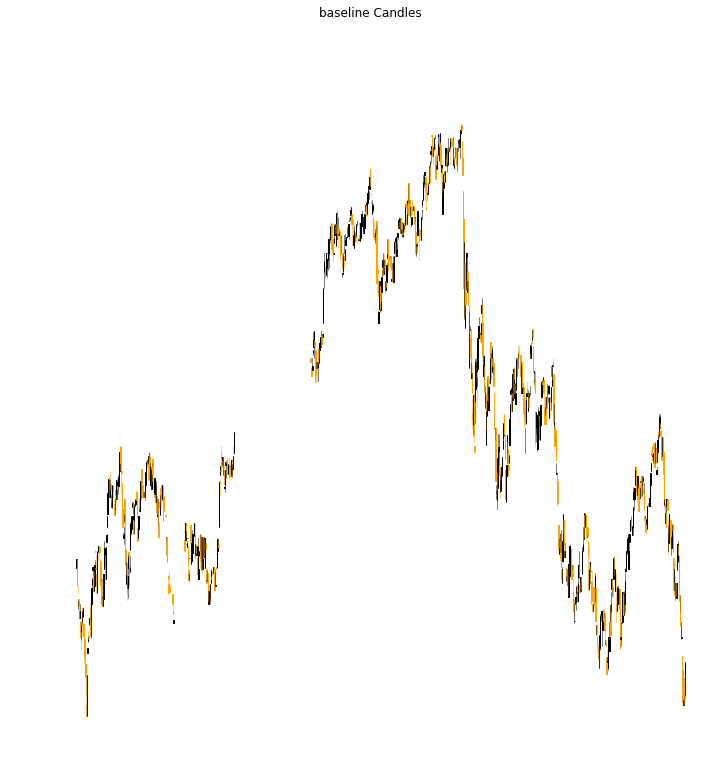

In [13]:
# filename = datasmith.random_filename
if True:
    filename = 'BTC_USDT.csv'
    datasmith.dataframe = filename
    df = datasmith.dataframe
    if True:
        chart = datasmith.candles
        candleChart(chart, 'baseline Candles')
    if False:
        chart2 = datasmith.make_candles(df, 'baseVolume')
        candleChart(chart2, 'Volume Candles???')

In [ ]:
# Set this to TRUE and then pick 1 of the test Scalers to test it.
if True:  # this is for the single run tests
    set__ = 'ETH_BTC'
    # cut_off = len(highvol_set[set__])-180  # 3 hours ago
    cut_off = 0  # all data
    if get_all:
        baseline = mega_set['BTC_USDT'][cut_off:]
        dataset = highvol_set[set__][cut_off:]
    else:
        filename = 'BTC_USDT.csv'
        datasmith.dataframe = filename
        baseline = datasmith.dataframe[cut_off:]
        filename = '{}.csv'.format(set__)
        datasmith.dataframe = filename
        dataset = datasmith.dataframe[cut_off:]
    

    ## TODO:: MAKE DATA FOR THIS 2 COLUMN COMPARERATOR
    x_ = unzero(baseline['last'].pct_change(60))
    y_ = unzero(dataset['last'].pct_change(60))
    real_scatter = np.array([[x,y] for x, y in zip(x_, y_)])
    print(real_scatter.shape)

    if False:
        hex_bins(data=real_scatter, title='Real Values')
    if True:
        minMax_scatter = MinMaxScaler().fit_transform(real_scatter)
        hex_bins(minMax_scatter, "Min Max Scaler")
    if False:
        plottings = QuantileTransformer(output_distribution='normal').fit_transform(real_scatter)
        hex_bins(plottings, 'Quantile Transformation (gaussian pdf)')
    if False:
        plottings = QuantileTransformer(output_distribution='uniform').fit_transform(real_scatter)
        hex_bins(plottings, 'Quantile Transformation (gaussian pdf)')
    if False:
        robust = RobustScaler(quantile_range=(1, 10)).fit_transform(real_scatter)
        hex_bins(robust, "Robust")
    if False:
        normalz = Normalizer().fit_transform(real_scatter)
        hex_bins(normalz, "Normalizer")

In [ ]:
if get_all:
    bg_text = 'ALPHAGRIFFIN.COM'
    txt_size = 20
    # plt.title(set__, y=.75, loc='left')
    for set__ in highvol_set:
        cut_off = len(highvol_set[set__])- (60*12)  # 12 hours ago
        baseline = mega_set['BTC_USDT'][cut_off:]
        dataset = highvol_set[set__][cut_off:]
        pair = set__

        fig = plt.figure(
            figsize=(12,12),
            facecolor='white',
            edgecolor='black'                    
        )
        fig.suptitle('AlphaGriffin | Bittrex {} | 12 Hour Chart'.format(pair))
        gs = plt.GridSpec(5, 2)

        ax1 = fig.add_subplot(gs[0,:-1])
        ax1.plot(dataset['timestamp'], dataset['last'], alpha=0.35)
        ax1.plot(dataset['timestamp'], dataset['last'].rolling(window=7).mean(), color='green', alpha=0.85)
        ax1.plot(dataset['timestamp'], dataset['last'].rolling(window=12).mean(), color='red', alpha=0.65)
        ax1.set_title('Closing minute price', y=.01, x=.01)
        txt1 = ax1.text(.15, .05, bg_text, transform=ax1.transAxes, alpha=.05);
        txt1.set_size(txt_size)
        ax1.axis('off')
        ax1.spines['top'].set_visible(True)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)

        ax2 = fig.add_subplot(gs[3,:-1])
        ax2.plot(dataset['timestamp'], dataset['change'], alpha=0.35)
        ax2.plot(dataset['timestamp'], dataset['change'].rolling(window=7).mean(), color='green', alpha=0.85)
        ax2.plot(dataset['timestamp'], dataset['change'].rolling(window=12).mean(), color='red', alpha=0.65)
        ax2.set_title('24 Hour Change', y=.01, x=.01)
        txt2 = ax2.text(.15, .05, bg_text, transform=ax2.transAxes, alpha=.05);
        txt2.set_size(txt_size)
        ax2.axis('off')

        ax3 = fig.add_subplot(gs[1,:-1])
        ax3.plot(dataset['timestamp'], pd.Series(dataset['baseVolume']*dataset['last']), alpha=0.35)
        ax3.plot(dataset['timestamp'], pd.Series(dataset['baseVolume']*dataset['last']).rolling(window=7).mean(), color='green', alpha=0.85)
        ax3.plot(dataset['timestamp'], pd.Series(dataset['baseVolume']*dataset['last']).rolling(window=12).mean(), color='red', alpha=0.65)
        ax3.set_title('Volume in BTC', y=.01, x=.01)
        txt3 = ax3.text(.15, .05, bg_text, transform=ax3.transAxes, alpha=.05);
        txt3.set_size(txt_size)
        ax3.axis('off')


        ax4 = fig.add_subplot(gs[2,:-1])
        hour_change = unzero(dataset['last'].pct_change(60))
        ax4.plot(range(len(hour_change)), hour_change, alpha=.35)
        ax4.plot(range(len(hour_change)), hour_change.rolling(window=7).mean(), color='green', alpha=.85)
        ax4.plot(range(len(hour_change)), hour_change.rolling(window=12).mean(), color='red', alpha=.65)
        ax4.set_title('8 Hour Change', y=.01, x=.01)
        txt4 = ax4.text(.15, .05, bg_text, transform=ax4.transAxes, alpha=.05);
        txt4.set_size(txt_size)
        ax4.axis('off')

        baseline_ax = fig.add_subplot(gs[4,:-1])
        baseline_change = unzero(baseline['last'].pct_change(60))
        baseline_ax.plot(range(len(baseline_change)), baseline_change, alpha=.35)
        baseline_ax.plot(range(len(baseline_change)), baseline_change.rolling(window=7).mean(), color='green', alpha=.85)
        baseline_ax.plot(range(len(baseline_change)), baseline_change.rolling(window=12).mean(), color='red', alpha=.65)
        baseline_ax.set_title('24 Hour Baseline Change', y=.01, x=.01)
        txt5 = baseline_ax.text(.15, .05, bg_text, transform=baseline_ax.transAxes, alpha=.05);
        txt5.set_size(txt_size)
        baseline_ax.axis('off')

        # SCATTER AND HISTO COMBO
        x_ = baseline_change
        y_ = hour_change
        real_scatter = np.array([[x,y] for x, y in zip(baseline_change, hour_change)])
        # plottings = QuantileTransformer(output_distribution='uniform').fit_transform(real_scatter)
        plottings = robust = RobustScaler(quantile_range=(1, 10)).fit_transform(real_scatter)
        hex_bins(data=plottings, fig=fig, title='Quantile Transformation (gaussian pdf)')

        # TEXT BREAKDOWNS
        other_ax = fig.add_subplot(gs[2,1:])
        other_ax.axis('off')
        othertxt = other_ax.text(.15, .95, "Test Text Here", transform=other_ax.transAxes, alpha=.95);
        othertxt.set_size(txt_size)

        # TEXT BREAKDOWNS
        other1_ax = fig.add_subplot(gs[3,1:])
        other1_ax.axis('off')
        other1txt = other1_ax.text(.15, .05, "Test Text Here", transform=other1_ax.transAxes, alpha=.95);
        other1txt.set_size(txt_size)

        # TEXT BREAKDOWNS
        text_ax = fig.add_subplot(gs[4,1:])
        text_ax.axis('off')
        txtline1 = text_ax.text(.15, .05, "Test Text Here", transform=text_ax.transAxes, alpha=.95);
        txtline1.set_size(txt_size)
        plt.show();
        plt.clf();
        # break

In [4]:
def graph_dataframe(dataset, baseline, period='15m'):
    bg_text = 'ALPHAGRIFFIN.COM'
    txt_size = 20
    cut_off = len(dataset) - (60*12)  # 12 hours ago
    pair = df.pair

    fig = plt.figure(
        figsize=(12,12),
        facecolor='white',
        edgecolor='black'                    
    )
    fig.suptitle('AlphaGriffin | Bittrex {} | 12 Hour Chart'.format(pair))
    gs = plt.GridSpec(5, 2)
    frames = []
    for i in gs:
        frames.append(i)
    for i, e in enumerate(frames):
        ax = fig.add_subplot(e)
        ax.set_title('Plot #{}'.format(i))
        bgtxt = ax.text(.15, .05, bg_text, transform=ax.transAxes, alpha=.05);
        bgtxt.set_size(txt_size)
        # ax.axis('off')
    fig.subplots_adjust(left=0, right=1,
                    top=1, bottom=0,
                    hspace=0, wspace=0)   
    plt.show()

In [5]:
graph_dataframe(dataset, baseline, '30m')

NameError: name 'dataset' is not defined

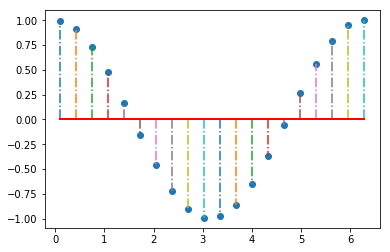

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.clf();
x = np.linspace(0.1, 2 * np.pi, 20)
markerline, stemlines, baseline = plt.stem(x, np.cos(x), '-.')
plt.setp(baseline, color='r', linewidth=2)

plt.show()